# Credit Risk Assessment: LightGBM Model Tuning

---

### Import Libraries and set Configurations

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import joblib
import optuna
import lightgbm as lgb
from scipy import sparse
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_recall_curve, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
import shap
import warnings
from aura.utils.pathing import models,reports, root
from datetime import date
import json

warnings.filterwarnings("ignore")
data = Path("../data/processed")
random_state=42
stamp = date.today().isoformat()

### Load Data

In [3]:
X_train = sparse.load_npz(data/"X_train.npz")
X_test = sparse.load_npz(data/"X_test.npz")
y_train = pd.read_csv(data/"y_train.csv").squeeze("columns")
y_test = pd.read_csv(data/"y_test.csv").squeeze("columns")
pre = joblib.load(data / "preprocessor.joblib")
all_features = pre.get_feature_names_out()
print("train", X_train.shape, " test", X_test.shape)

train (1076248, 134)  test (269062, 134)


### Tune LightGBM Model

In [4]:
model_version = "v1"
gbm_path = models / f"lgbm_{model_version}.joblib"
params_path = models / f"params_lightgbm_{model_version}.json"
if gbm_path.exists():
    print("Using cached LightGBM:", gbm_path.name)
    gbm = joblib.load(gbm_path)
else:
    pre = joblib.load(data / "preprocessor.joblib")
    all_features = pre.get_feature_names_out()
    mono_vec = [ {"num__dti":1,"num__loan_to_income":1,
                  "num__installment_to_income":1,"num__credit_age_months":-1,
                  "ord__grade":1,"ord__sub_grade":1}.get(f,0)
                 for f in all_features ]

    def objective(trial):
        params = {
            "objective": "binary",
            "metric": "auc",
            "boosting_type": "gbdt",
            "verbosity": -1,                 
            "learning_rate":trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "num_leaves":trial.suggest_int("num_leaves", 31, 511, log=True),
            "max_depth":trial.suggest_int("max_depth", 3, 16),
            "min_child_samples": trial.suggest_int("min_child_samples", 20, 1000, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),  
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),       
            "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
            "class_weight":"balanced",
            "monotone_constraints": mono_vec,
            "force_col_wise":True,
            "random_state":random_state,
        }

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        aucs=[]
        for tr,va in cv.split(X_train, y_train):
            bst = lgb.train(params,
                            lgb.Dataset(X_train[tr], y_train.iloc[tr]),
                            num_boost_round=5000,
                            valid_sets=[lgb.Dataset(X_train[va], y_train.iloc[va])],
                            callbacks=[lgb.early_stopping(200, verbose=False)])
            aucs.append(roc_auc_score(y_train.iloc[va], bst.predict(X_train[va])))
        return np.mean(aucs)

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=60, timeout=3600)
    best_params = study.best_params
    best_params |= {
    "objective": "binary",
    "metric": "auc",
    "class_weight": "balanced",
    "monotone_constraints": mono_vec,
    "force_col_wise": True,
    "random_state": random_state,
}
    gbm = lgb.LGBMClassifier(**best_params).fit(X_train, y_train)

    joblib.dump(gbm, gbm_path)
    with open(params_path,"w") as fp: json.dump(best_params, fp, indent=2)

Using cached LightGBM: lgbm_v1.joblib


### Model Evaluation

metrics markdown written: reports/metrics_lightgbm.md


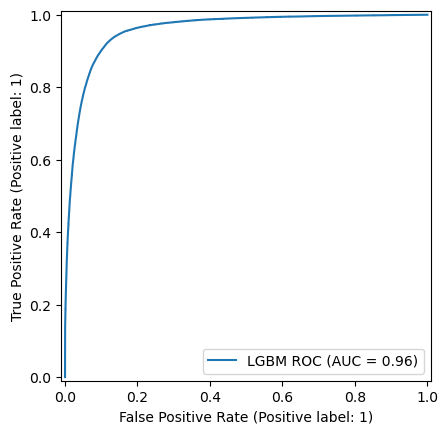

In [6]:
preds = gbm.predict_proba(X_test)[:, 1]
y_pred = (preds > 0.70).astype(int)        
auc = roc_auc_score(y_test, preds)
pr_auc= average_precision_score(y_test, preds)
report= classification_report(y_test, y_pred, digits=3, zero_division=0)
acc= (y_pred == y_test).mean()
cm= confusion_matrix(y_test, y_pred)

md = reports / "metrics_lightgbm.md"
with open(md, "w") as f:
    f.write(f"# LightGBM – {stamp}\n\n")
    f.write("| Metric | Value |\n|--------|-------|\n")
    f.write(f"| ROC-AUC | **{auc:.4f}** |\n")
    f.write(f"| PR-AUC  | **{pr_auc:.3f}** |\n")
    f.write(f"| Accuracy| **{acc:.3f}** |\n\n")
    f.write("<details><summary>Classification report</summary>\n\n```\n")
    f.write(report)
    f.write("\n```\n</details>\n")
print("metrics markdown written:", md.relative_to(root))

fig_roc = RocCurveDisplay.from_predictions(y_test, preds, name="LGBM ROC")
fig_roc.figure_.savefig(reports / "figs" / "roc_lgbm.png", dpi=300)